## <a id="Customer-Segmentation-Report">Part 1: Customer Segmentation Report</a>

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [1]:
import numpy as np
import pandas as pd
import sys
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.externals import joblib
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import dsp


/Users/jamancilla/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/jamancilla/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# load the cleaned data
azdias_clean = pd.read_csv('data/Udacity_AZDIAS_052018_clean.csv', sep=';')

In [3]:
# Load cleaned customer data
customers_clean = pd.read_csv('data/Udacity_CUSTOMERS_052018_clean.csv', sep=';')

### Step 1. Feature Scaling

In [4]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
azdias_impute = imputer.fit_transform(azdias_clean)
print(np.isnan(azdias_impute).sum())

0


In [5]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_impute)

### Step 2. PCA

In [6]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)


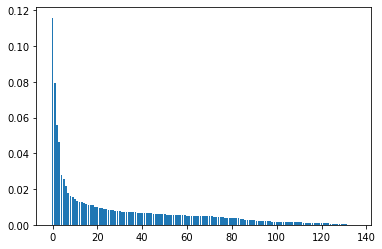

In [7]:
# Investigate the variance accounted for by each principal component.
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
plt.bar(ind, vals)
plt.show()

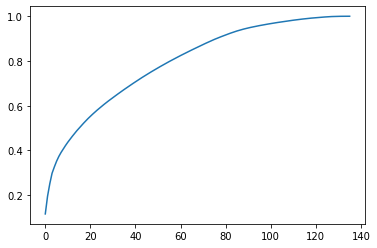

In [8]:
cumvals = np.cumsum(vals)
plt.plot(cumvals)
plt.show()

In [9]:
threshold = .85
i = np.argmax(cumvals > threshold)
print(i, cumvals[i])

66 0.8542654212225473


In [10]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(i)
azdias_pca = pca.fit_transform(azdias_scaled)

#### Step 2.1 PCA Interpretation

#### First principal component

In [11]:
i = 0
print('{:5.2%}'.format(vals[i]))
dsp.print_interesting_features(azdias_clean.columns.values, pca.components_, i)

11.59%
Lowest:
	HH_EINKOMMEN_SCORE   -0.151
	CAMEO_DEUG_2015      -0.144
	wealth               -0.142
Highest:
	D19_VERSAND_ANZ_24   0.159
	ONLINE_AFFINITAET    0.167
	D19_GESAMT_ANZ_24    0.173


Lowest:
- HH_EINKOMMEN_SCORE is estimated household net income (1 = highest income group)
- CAMEO_DEUG_2015 is CAMEO major classification 2015 (1 = upper class)
- wealth was derived from CAMEO_INTL_2015 (1 = wealthy)

Highest:
- D19_VERSAND_ANZ_24 is transaction activity MAIL-ORDER in the last 12 months (6 = very high activity)
- ONLINE_AFFINITAET is online affinity (5 = highest)
- D19_GESAMT_ANZ_24 is mail-order transaction activity TOTAL POOL in the last 24 months (6 = very high activity)

PCA0 is an indicator of purchasing activity and wealth. Note, the indicators for wealth are all inverted with 1 indicating highest wealth.

#### Second principal component

In [12]:
i = 1
print('{:5.2%}'.format(vals[i]))
dsp.print_interesting_features(azdias_clean.columns.values, pca.components_, i)

7.91%
Lowest:
	ALTERSKATEGORIE_GROB -0.231
	FINANZ_VORSORGER     -0.215
	FINANZ_MINIMALIST    -0.185
Highest:
	SEMIO_REL            0.208
	decade               0.229
	FINANZ_SPARER        0.240


Lowest:
- ALTERSKATEGORIE_GROB is age major category (4	= > 60 years)
- FINANZ_VORSORGER is financial typology: be prepared  (1 = very high)
- FINANZ_MINIMALIST is financial typology: low financial interest (1 = very high)

Highest:
- SEMIO_REL is affinity indicating in what way the person is religious (1 = highest affinity)
- decade was derived from PRAEGENDE_JUGENDJAHRE (1 = 40's, 15 = 90's)
- FINANZ_SPARER is financial typology: money saver (1 = very high)

PCA1 is a indicator of lack of religiousness, youth, free spending

#### Third principal component

In [13]:
i = 2
print('{:5.2%}'.format(vals[i]))
dsp.print_interesting_features(azdias_clean.columns.values, pca.components_, i)

5.61%
Lowest:
	SEMIO_KULT           -0.171
	SEMIO_REL            -0.166
	PLZ8_ANTG1           -0.165
Highest:
	EWDICHTE             0.169
	PLZ8_ANTG3           0.170
	ORTSGR_KLS9          0.172


Lowest:
- SEMIO_KULT is affinity indicating in what way the person is cultural minded (1 = highest affinity)
- SEMIO_REL is affinity indicating in what way the person is religious (1 = highest affinity)
- PLZ8_ANTG1 is number of 1-2 family houses in the zipcode (3 = high share)

Highest:
- EWDICHTE is population density (6 = densist)
- PLZ8_ANTG3 is number of 6-10 family houses in the zipcode (3 = high share)
- ORTSGR_KLS9 is size of the community, classified number of inhabitants (9 = > 700.000  inhabitants)

PCA2 is an indicator of population density and cultural minded/religiousness

#### Preprocess fit function

In [14]:
azdias_pca, imputer, scaler, pca = dsp.preprocess_fit(azdias_clean, pca_n=66, impute_strat='median')

In [16]:
# Check that the function is working correctly
vals = pca.explained_variance_ratio_

# First principal component
i = 0
print('{:5.2%}'.format(vals[i]))
dsp.print_interesting_features(azdias_clean.columns.values, pca.components_, i)

11.59%
Lowest:
	HH_EINKOMMEN_SCORE   -0.151
	CAMEO_DEUG_2015      -0.144
	wealth               -0.142
Highest:
	D19_VERSAND_ANZ_24   0.159
	ONLINE_AFFINITAET    0.167
	D19_GESAMT_ANZ_24    0.173


### Step 3. Clustering

In [17]:
# Over a number of different cluster counts...
N = azdias_pca.shape[0]
mean_d = []
centers = range(2, 11)
for k in centers:

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    mean_d.append(abs(model.score(azdias_pca))/N)


[104.33770557876389, 98.60183755655761, 94.82053132337737, 92.68092608797056, 91.02772464228707, 89.43313660799177, 88.14367018549764, 86.95582272273077, 85.95729067549705, 85.05144325691465, 84.13214814392857, 83.38811948095271, 82.69777824985744, 81.91144536959737]


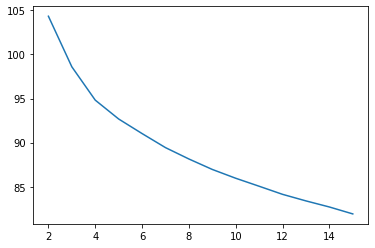

In [22]:
# Investigate the change in within-cluster distance across number of clusters.
print(mean_d)
plt.plot(range(2, len(mean_d) + 2), mean_d);



[104.33770557876389, 98.60183755655761, 94.82053132337737, 92.68092608797056, 91.02772464228707, 89.43313660799177, 88.14367018549764, 86.95582272273077, 85.95729067549705, 85.05144325691465, 84.13214814392857, 83.38811948095271, 82.69777824985744, 81.91144536959737]


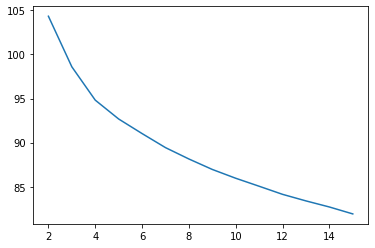

In [19]:
centers = range(11, 16)
for k in centers:

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    mean_d.append(abs(model.score(azdias_pca))/N)

print(mean_d)
plt.plot(range(2, len(mean_d) + 2), mean_d);



In [20]:
# Train clustering model with k=8
k = 8
kmeans = KMeans(n_clusters=k)
clust_model = kmeans.fit(azdias_pca)

population_labels = clust_model.predict(azdias_pca)
population_labels[:10]

array([1, 0, 0, 4, 3, 3, 3, 0, 6, 5], dtype=int32)

#### Step 3.1 Build model

In [23]:
pca_n = 76
n_clusters = 5
clust_model = dsp.build_model(pca_n, n_clusters)

print('Fitting model...')
clust_model.fit(azdias_clean)

print('Saving model...')
f = open('clust_model' + str(n_clusters) + '.pkl', 'wb')
pickle.dump(clust_model, f)

Fitting model...
Saving model...


In [5]:
# or load model if already fitted
clust_model = joblib.load('models/clust_model5.pkl')

In [6]:
population_labels = clust_model.predict(azdias_clean)
population_labels[:10]

array([3, 1, 1, 0, 3, 3, 4, 1, 0, 2], dtype=int32)

In [7]:
customer_labels = clust_model.predict(customers_clean)
customer_labels[:10]

array([1, 2, 1, 0, 1, 1, 1, 2, 0, 0], dtype=int32)

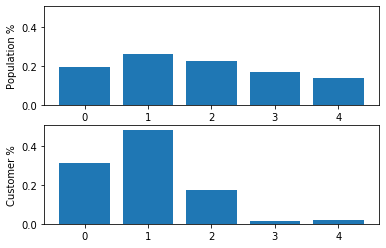

In [8]:
# Five clusters
dsp.print_cluster_props(population_labels,customer_labels)

In [11]:
# PCA
for i in range(3):
    print('PCA', i)
    dsp.print_interesting_features(azdias_clean.columns.values, clust_model.named_steps['pca'].components_, i)
    print()

PCA 0
Lowest:
	HH_EINKOMMEN_SCORE   -0.151
	CAMEO_DEUG_2015      -0.144
	wealth               -0.142
Highest:
	D19_VERSAND_ANZ_24   0.159
	ONLINE_AFFINITAET    0.167
	D19_GESAMT_ANZ_24    0.173

PCA 1
Lowest:
	ALTERSKATEGORIE_GROB -0.231
	FINANZ_VORSORGER     -0.215
	FINANZ_MINIMALIST    -0.185
Highest:
	SEMIO_REL            0.208
	decade               0.229
	FINANZ_SPARER        0.240

PCA 2
Lowest:
	SEMIO_KULT           -0.171
	SEMIO_REL            -0.166
	PLZ8_ANTG1           -0.165
Highest:
	EWDICHTE             0.169
	PLZ8_ANTG3           0.170
	ORTSGR_KLS9          0.172



- PCA0 is an indicator of purchasing activity and wealth
- PCA1 is a indicator of lack of religiousness, youth, free spending
- PCA2 is an indicator of population density and urbaness

In [12]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cust = pd.Series(customer_labels)
cust_p = cust.value_counts() / cust.value_counts().sum()
cust_p.sort_index()

0    0.310877
1    0.482777
2    0.172527
3    0.014422
4    0.019398
dtype: float64

In [13]:
# First three PCA values for Cluster Centroids
clusters_df=pd.DataFrame(clust_model.named_steps['kmeans'].cluster_centers_[:,:3])
clusters_df.index.name = 'cluster'
clusters_df.sort_index(ascending=False)

,0,1,2
cluster,,,
4,-1.649158,3.278136,-2.243211
3,-2.137902,2.785425,-0.455594
2,-3.535780,-1.392838,2.166314
1,0.999575,-3.344071,-1.141813
0,5.804745,1.350414,1.028975


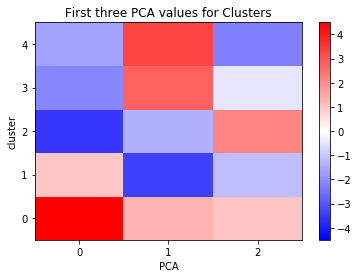

In [14]:
color_map = matplotlib.cm.get_cmap('bwr')

plt.pcolor(clusters_df, cmap=color_map, vmin=-4.5, vmax=4.5);
plt.title('First three PCA values for Clusters')
plt.ylabel('cluster')
plt.xlabel('PCA')

plt.yticks(np.arange(0.5, len(clusters_df.index)), clusters_df.index)
plt.xticks(np.arange(0.5, 3), clusters_df.index)

plt.colorbar()

plt.show()

A heatmap of the clusters and their PCA values shows that at five clusters the clusters are easily distinguishable from one another using the first three PCA components.